In [35]:
import tensorflow as tf
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tqdm
import seaborn as sns
from tensorflow import keras
from keras import Input, Model, Sequential
from tensorflow.keras.regularizers import l2
from keras.layers import Dense, Flatten, InputLayer, Reshape, BatchNormalization, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.utils import plot_model

%matplotlib inline

In [36]:
categories = {
    'cleanwater' :0,
    'Lake' :1,
    'Pond' :2
}
print(categories)

{'cleanwater': 0, 'Lake': 1, 'Pond': 2}


In [37]:
def load_images(images_folder, img_size = (256, 256), scale=False):

    # Store paths to images
    image_path = []
    for dirname, _, filenames in os.walk(images_folder):
        for filename in filenames:
            image_path.append(os.path.join(dirname, filename))

    print("There are {} images in {}".format(len(image_path), images_folder))
    
    # Load images and associated labels
    images = []
    labels = []

    for path in tqdm.tqdm(image_path):

        img = cv2.imread(path)    
        img = cv2.resize(img, img_size) # Resize the images

        img = np.array(img)

        images.append(img)
        labels.append(categories[path.split('/')[-2]]) # last folder before the image name is the category

    images = np.array(images)  
    images = images.astype(np.int64)
    
    if scale:
        images = images/255 # scale
        
    return image_path, images, np.asarray(labels)

In [38]:
#main = '/content/drive/MyDrive/Thesis Data/Brain Patients -HG LG - Copy - Copy'
#second= '/content/drive/MyDrive/Thesis Data/Brain Patients -HG LG - Copy - Copy'
img_size = (256, 256)
images_folder = os.path.join('/content/drive/MyDrive/computer_vision/water analysis')
image_path, images, labels = load_images(images_folder, img_size=img_size)

# Resize
# images = np.array(images).reshape(-1,256,256,1)
images.shape

There are 239 images in /content/drive/MyDrive/computer_vision/water analysis


100%|██████████| 239/239 [00:03<00:00, 75.77it/s]


(239, 256, 256, 3)

In [39]:
print(images.shape)
print(labels.shape)

(239, 256, 256, 3)
(239,)


#Visualization

In [40]:
set(labels)

{0, 1, 2}

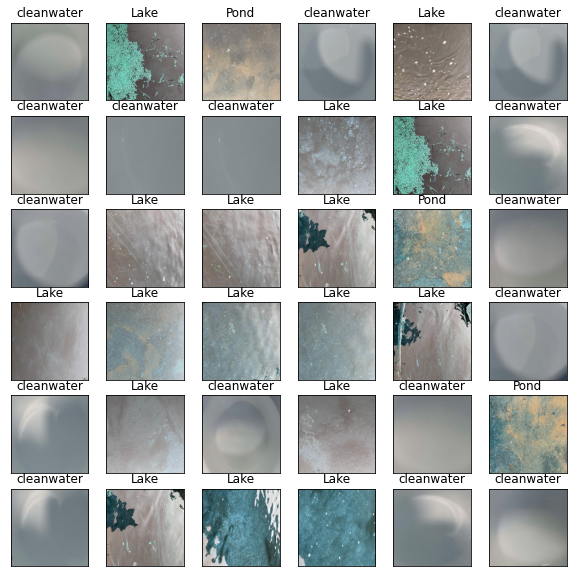

In [41]:
plt.figure(figsize=(10,10))
random_inds = np.random.choice(len(image_path),36)
for i in range(36):
    plt.subplot(6,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image_ind = random_inds[i]
    plt.imshow(np.squeeze(images[image_ind]), cmap=plt.cm.binary)
    
    label = list(categories.keys())[list(categories.values()).index(labels[image_ind])]
    plt.title(label)

#How are the categories distributed?

In [43]:
labels_df = pd.DataFrame(labels) 
labels_df.value_counts()

1    104
0     96
2     39
dtype: int64

#Split Data

In [44]:
from sklearn.model_selection import train_test_split
# Train, validation and test split

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.15, random_state=7)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=1) 

In [45]:
print("*-*-*-*-*-*")
print("Train")
print(X_train.shape)
print(y_train.shape)


print("*-*-*-*-*-*")
print("Validation")
print(X_val.shape)
print(y_val.shape)


print("*-*-*-*-*-*")
print("Test")
print(X_test.shape)
print(y_test.shape)

*-*-*-*-*-*
Train
(172, 256, 256, 3)
(172,)
*-*-*-*-*-*
Validation
(31, 256, 256, 3)
(31,)
*-*-*-*-*-*
Test
(36, 256, 256, 3)
(36,)


In [46]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
le = LabelEncoder()
labels = le.fit_transform(labels)
labels = to_categorical(labels)
labels[:10]

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

#Build Model

In [47]:
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from keras.layers import *
from keras import models
model = models.Sequential()
from keras.preprocessing import image

In [48]:
from tensorflow.keras.applications import InceptionV3
conv_base = InceptionV3(weights='imagenet',
                              include_top=False,
                              input_shape=(256, 256, 3))

In [52]:
from keras import models
from keras import layers
model = models.Sequential()
model.add(conv_base)
model.add(Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(layers.Dense(3, activation='softmax'))

In [53]:
model.compile(optimizer = "rmsprop", loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])

In [54]:
history = model.fit(X_train, y_train, 
                    validation_data = (X_val, y_val),
                  batch_size = 20, epochs = 30)

Epoch 1/30
9/9 [==============================] - 15s 393ms/step - loss: 2.7101 - accuracy: 0.4767 - val_loss: 522481.2812 - val_accuracy: 0.4194
Epoch 2/30
9/9 [==============================] - 2s 228ms/step - loss: 3.1712 - accuracy: 0.4535 - val_loss: 96.4730 - val_accuracy: 0.3871
Epoch 3/30
9/9 [==============================] - 2s 228ms/step - loss: 1.0159 - accuracy: 0.4535 - val_loss: 487.0624 - val_accuracy: 0.3548
Epoch 4/30
9/9 [==============================] - 2s 223ms/step - loss: 1.1353 - accuracy: 0.5581 - val_loss: 201.8932 - val_accuracy: 0.3548
Epoch 5/30
9/9 [==============================] - 2s 228ms/step - loss: 1.0201 - accuracy: 0.5872 - val_loss: 109.2851 - val_accuracy: 0.3871
Epoch 6/30
9/9 [==============================] - 2s 223ms/step - loss: 1.6416 - accuracy: 0.5174 - val_loss: 5222.8296 - val_accuracy: 0.3548
Epoch 7/30
9/9 [==============================] - 2s 225ms/step - loss: 0.7755 - accuracy: 0.6802 - val_loss: 1.8246 - val_accuracy: 0.4839
Epoc

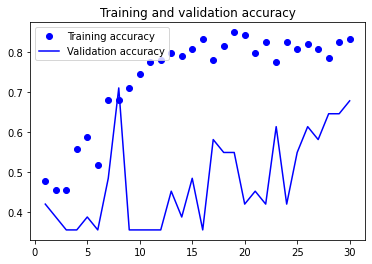

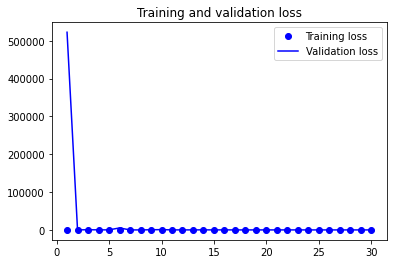

In [55]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()


In [56]:
model.save('water_analysis.h5')

In [57]:
model.evaluate(X_test, y_test)

2/2 [==============================] - 0s 40ms/step - loss: 0.8558 - accuracy: 0.6667


[0.8558498024940491, 0.6666666865348816]

In [65]:
# Predict on test set
y_pred = model.predict(X_test)
y_pred

array([[2.13431055e-03, 9.97799218e-01, 6.64458930e-05],
       [1.00000000e+00, 5.26799507e-11, 2.40769956e-11],
       [1.73239261e-01, 8.11622202e-01, 1.51385702e-02],
       [9.94785368e-01, 4.22487874e-03, 9.89734428e-04],
       [5.42418808e-02, 5.42505503e-01, 4.03252602e-01],
       [2.45518591e-02, 6.12200737e-01, 3.63247395e-01],
       [1.00000000e+00, 5.18329650e-11, 8.44562809e-13],
       [5.32013699e-02, 5.42703748e-01, 4.04094875e-01],
       [1.00000000e+00, 1.15012465e-10, 2.69154213e-11],
       [5.93247451e-03, 9.94036198e-01, 3.12834745e-05],
       [3.60981114e-02, 5.80438375e-01, 3.83463532e-01],
       [9.93859529e-01, 6.06613327e-03, 7.42544216e-05],
       [7.41946697e-01, 1.69875190e-01, 8.81781578e-02],
       [2.55104669e-06, 9.99979615e-01, 1.79349372e-05],
       [1.00000000e+00, 3.66679673e-11, 9.10758882e-12],
       [3.99726182e-02, 9.15439308e-01, 4.45880443e-02],
       [5.35535872e-01, 2.65180588e-01, 1.99283585e-01],
       [3.02014798e-02, 5.94858

In [98]:
y_pred = model.predict(X_test, verbose=0)
y_pred.shape

(36, 3)

In [99]:
# From categorical outputs to discrete values

y_pred_ = [np.argmax(y) for y in y_pred]
y_test_ = [np.argmax(y) for y in y_test]

In [100]:
from sklearn.metrics import classification_report
print(classification_report(y_test_, y_pred_))

              precision    recall  f1-score   support

           0       1.00      0.47      0.64        36
           1       0.00      0.00      0.00         0

    accuracy                           0.47        36
   macro avg       0.50      0.24      0.32        36
weighted avg       1.00      0.47      0.64        36



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#Confusion Matrix

In [83]:
y_pred = model.predict(X_test, verbose=0)
y_pred.shape

(36, 3)

In [85]:
rounded_prediction = np.argmax(y_pred, axis=-1)
cm = confusion_matrix(y_true=y_test , y_pred=rounded_prediction)


In [86]:
print(cm)

[[10  0  0]
 [ 6 14  0]
 [ 1  5  0]]


In [87]:
from sklearn.metrics import confusion_matrix
c_matrix = confusion_matrix(y_true=y_test , y_pred=rounded_prediction)
#c_matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

In [88]:
c_matrix

array([[10,  0,  0],
       [ 6, 14,  0],
       [ 1,  5,  0]])

In [89]:
import seaborn as sns
def confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

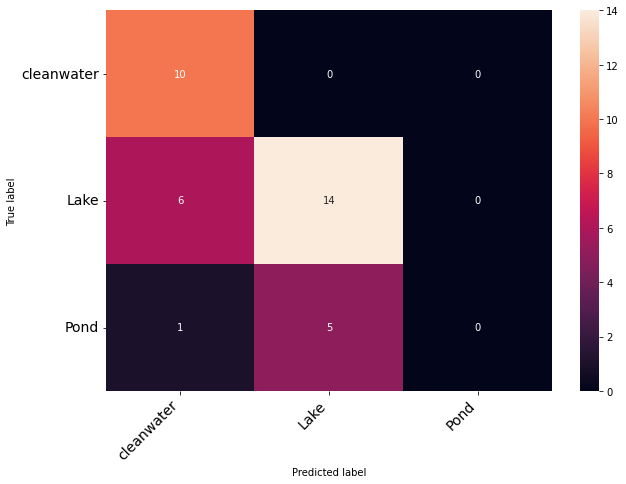

In [90]:

confusion_matrix(c_matrix, categories, figsize = (10,7), fontsize=14)

In [75]:
def predict_class(img):
    # Resize
    img = img.reshape(1,256,256,3)
    # Predict
    predictions = model.predict(img)
    true_prediction = [tf.argmax(pred) for pred in predictions]
    true_prediction = np.array(true_prediction)
    
    # Return label corresponding to predicted index
    return list(categories.keys())[list(categories.values()).index(true_prediction)]
    

In [76]:
predict_class(X_test[0])

'Lake'

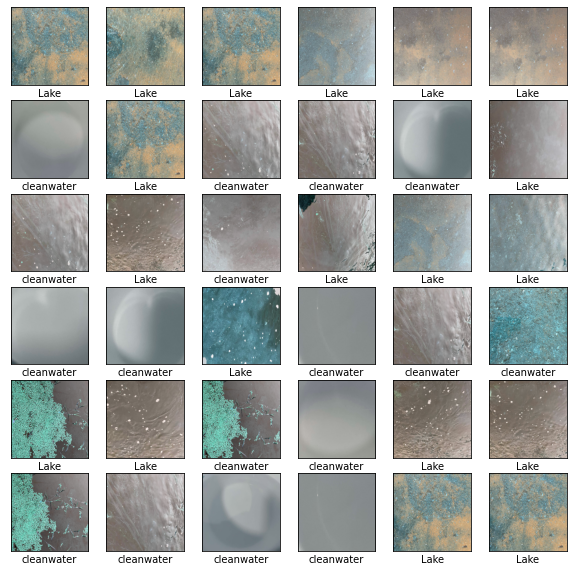

In [77]:
plt.figure(figsize=(10,10))
random_inds = np.random.choice(X_test.shape[0],36)
for i in range(36):
    plt.subplot(6,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image_ind = random_inds[i]
    plt.imshow(np.squeeze(X_test[image_ind]), cmap=plt.cm.binary)
    
    # Predict and get label
    label = predict_class(X_test[image_ind])
    plt.xlabel(label)